![Quora-1.png](attachment:Quora-1.png)

<h1 style="text-align:center;font-size:30px;" > Quora Question Pairs </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 


__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

<h2> 1.2 Sources/Useful Links</h2>

- Source : https://www.kaggle.com/c/quora-question-pairs
<br><br>____ Useful Links ____
- Discussions : https://www.kaggle.com/anokas/data-analysis-xgboost-starter-0-35460-lb/comments
- Kaggle Winning Solution and other approaches: https://www.dropbox.com/sh/93968nfnrzh8bp5/AACZdtsApc1QSTQc7X0H3QZ5a?dl=0
- Blog 1 : https://engineering.quora.com/Semantic-Question-Matching-with-Deep-Learning
- Blog 2 : https://towardsdatascience.com/identifying-duplicate-questions-on-quora-top-12-on-kaggle-4c1cf93f1c30

<h2>1.3 Real world/Business Objectives and Constraints </h2>

1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

<h1>2. Machine Learning Probelm </h1>

<h2> 2.1 Data </h2>

<h3> 2.1.1 Data Overview </h3>

<h3> 2.1.2 Example Data point </h3>

<pre>
"id","qid1","qid2","question1","question2","is_duplicate"
"0","1","2","What is the step by step guide to invest in share market in india?","What is the step by step guide to invest in share market?","0"
"1","3","4","What is the story of Kohinoor (Koh-i-Noor) Diamond?","What would happen if the Indian government stole the Kohinoor (Koh-i-Noor) diamond back?","0"
"7","15","16","How can I be a good geologist?","What should I do to be a great geologist?","1"
"11","23","24","How do I read and find my YouTube comments?","How can I see all my Youtube comments?","1"
</pre>

<h2> 2.2 Mapping the real world problem to an ML problem </h2>

<h3> 2.2.1 Type of Machine Leaning Problem </h3>

<p> It is a binary classification problem, for a given pair of questions we need to predict if they are duplicate or not. </p>

<h3> 2.2.2 Performance Metric </h3>

Source: https://www.kaggle.com/c/quora-question-pairs#evaluation

Metric(s): 
* log-loss : https://www.kaggle.com/wiki/LogarithmicLoss
* Binary Confusion Matrix

<h2> 2.3 Train and Test Construction </h2>

<p>  </p>
<p> We build train and test by randomly splitting in the ratio of 70:30 or 80:20 whatever we choose as we have sufficient points to work with. </p>

<h1>3. Exploratory Data Analysis </h1>

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup

<h2> 3.1 Reading data and basic stats </h2>

In [2]:
df = pd.read_csv("train.csv")

print("Number of data points:",df.shape[0])

Number of data points: 404290


In [3]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404289 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


We are given a minimal number of data fields here, consisting of:

- id:  Looks like a simple rowID
- qid{1, 2}:  The unique ID of each question in the pair
- question{1, 2}:  The actual textual contents of the questions.
- is_duplicate:  The label that we are trying to predict - whether the two questions are duplicates of each other.

<h3> 3.2.1 Distribution of data points among output classes</h3>
- Number of duplicate(smilar) and non-duplicate(non similar) questions

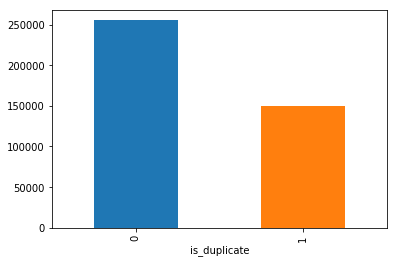

In [5]:
df.groupby("is_duplicate")['id'].count().plot.bar()

In [6]:
print('~> Total number of question pairs for training:\n   {}'.format(len(df)))

~> Total number of question pairs for training:
   404290


In [7]:
print('~> Question pairs are not Similar (is_duplicate = 0):\n   {}%'.format(100 - round(df['is_duplicate'].mean()*100, 2)))
print('\n~> Question pairs are Similar (is_duplicate = 1):\n   {}%'.format(round(df['is_duplicate'].mean()*100, 2)))

~> Question pairs are not Similar (is_duplicate = 0):
   63.08%

~> Question pairs are Similar (is_duplicate = 1):
   36.92%


<h3> 3.2.2 Number of unique questions </h3>

In [8]:
qids = pd.Series(df['qid1'].tolist() + df['qid2'].tolist())
unique_qs = len(np.unique(qids))
qs_morethan_onetime = np.sum(qids.value_counts() > 1)
print ('Total number of  Unique Questions are: {}\n'.format(unique_qs))
#print len(np.unique(qids))

print ('Number of unique questions that appear more than one time: {} ({}%)\n'.format(qs_morethan_onetime,qs_morethan_onetime/unique_qs*100))

print ('Max number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

q_vals=qids.value_counts()

q_vals=q_vals.values

Total number of  Unique Questions are: 537933

Number of unique questions that appear more than one time: 111780 (20.77953945937505%)

Max number of times a single question is repeated: 157



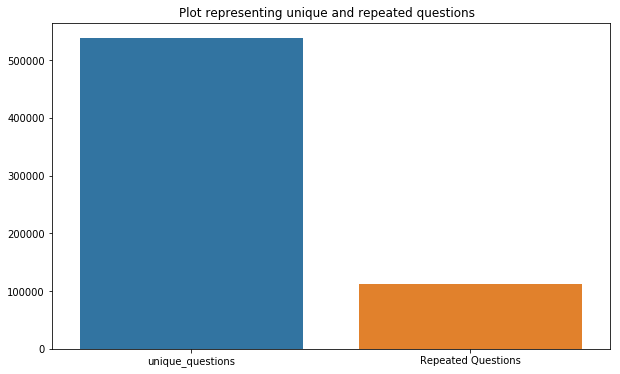

In [9]:

x = ["unique_questions" , "Repeated Questions"]
y =  [unique_qs , qs_morethan_onetime]

plt.figure(figsize=(10, 6))
plt.title ("Plot representing unique and repeated questions  ")
sns.barplot(x,y)
plt.show()

<h3>3.2.3 Checking for Duplicates </h3>

In [10]:
#checking whether there are any repeated pair of questions

pair_duplicates = df[['qid1','qid2','is_duplicate']].groupby(['qid1','qid2']).count().reset_index()

print ("Number of duplicate questions",(pair_duplicates).shape[0] - df.shape[0])

Number of duplicate questions 0


<h3> 3.2.4 Number of occurrences of each question </h3>

Maximum number of times a single question is repeated: 157



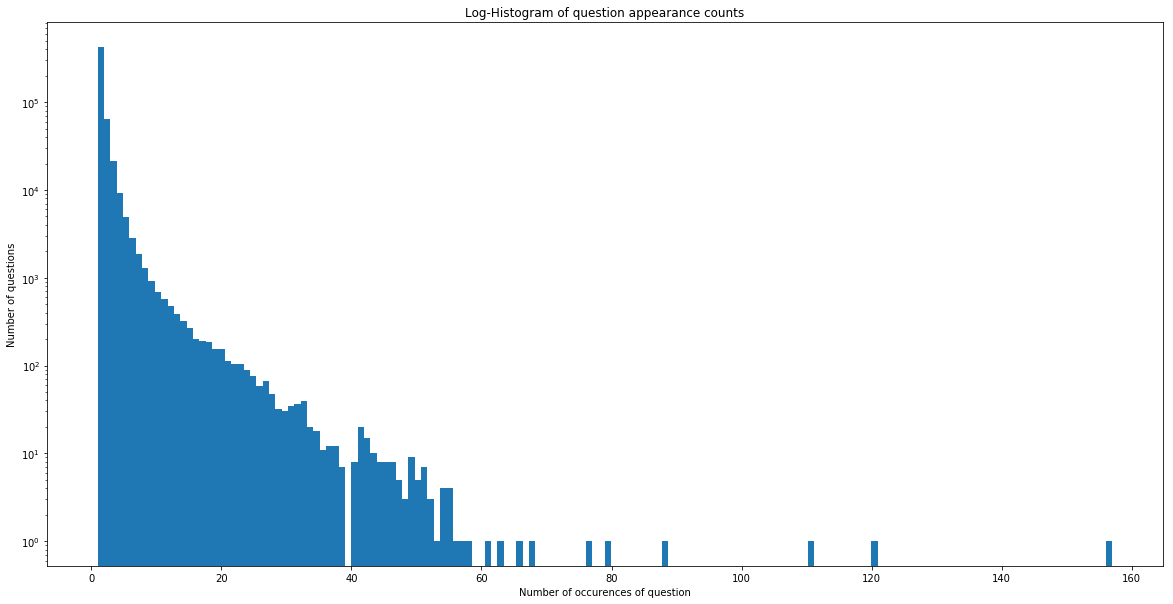

In [11]:
plt.figure(figsize=(20, 10))

plt.hist(qids.value_counts(), bins=160)

plt.yscale('log', nonposy='clip')

plt.title('Log-Histogram of question appearance counts')

plt.xlabel('Number of occurences of question')

plt.ylabel('Number of questions')

print ('Maximum number of times a single question is repeated: {}\n'.format(max(qids.value_counts()))) 

<h3> 3.2.5 Checking for NULL values </h3>

In [12]:
df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

id    qid1    qid2  \
0            0       1       2   
1            1       3       4   
2            2       5       6   
3            3       7       8   
4            4       9      10   
5            5      11      12   
6            6      13      14   
7            7      15      16   
8            8      17      18   
9            9      19      20   
10          10      21      22   
11          11      23      24   
12          12      25      26   
13          13      27      28   
14          14      29      30   
15          15      31      32   
16          16      33      34   
17          17      35      36   
18          18      37      38   
19          19      39      40   
20          20      41      42   
21          21      43      44   
22          22      45      46   
23          23      47      48   
24          24      49      50   
25          25      51      52   
26          26      53      54   
27          27      55      56   
28          28      57      58   
29          29      59      60   
...        ...     ...     ...   
404260  404260  182494     691   
404261  404261  281150  124172   
404262  404262  537905  466328   
404263  404263  375195  537906   
404264  404264  537907  537908   
404265  404265   25994   16064   
404266  404266  155813  146284   
404267  404267   20171  290649   
404268  404268  537909  537910   
404269  404269  537911  349794   
404270  404270  537912   35364   
404271  404271  537913  537914   
404272  404272  128018   14005   
404273  404273  537915  537916   
404274  404274  178643   87385   
404275  404275   97922  537917   
404276  404276   24305  308365   
404277  404277  355668  537918   
404278  404278  537919  169786   
404279  404279  537920  537921   
404280  404280  537922  537923   
404281  404281   99131   81495   
404282  404282    1931   16773   
404283  404283  537924  537925   
404284  404284  537926  537927   
404285  404285  433578  379845   
404286  404286   18840  155606   
404287  404287  537928  537929   
404288  404288  537930  537931   
404289  404289  537932  537933   

                                                question1  \
0       What is the step by step guide to invest in sh...   
1       What is the story of Kohinoor (Koh-i-Noor) Dia...   
2       How can I increase the speed of my internet co...   
3       Why am I mentally very lonely? How can I solve...   
4       Which one dissolve in water quikly sugar, salt...   
5       Astrology: I am a Capricorn Sun Cap moon and c...   
6                                     Should I buy tiago?   
7                          How can I be a good geologist?   
8                         When do you use シ instead of し?   
9       Motorola (company): Can I hack my Charter Moto...   
10      Method to find separation of slits using fresn...   
11            How do I read and find my YouTube comments?   
12                   What can make Physics easy to learn?   
13            What was your first sexual experience like?   
14      What are the laws to change your status from a...   
15      What would a Trump presidency mean for current...   
16                           What does manipulation mean?   
17      Why do girls want to be friends with the guy t...   
18      Why are so many Quora users posting questions ...   
19      Which is the best digital marketing institutio...   
20                             Why do rockets look white?   
21                  What's causing someone to be jealous?   
22        What are the questions should not ask on Quora?   
23                               How much is 30 kV in HP?   
24      What does it mean that every time I look at th...   
25      What are some tips on making it through the jo...   
26                               What is web application?   
27      Does society place too much importance on sports?   
28                 What is best way to make money online?   
29                 How should I prepare for CA final law?   
...         

In [13]:
pd.isnull(df).sum()

id              0
qid1            0
qid2            0
question1       1
question2       2
is_duplicate    0
dtype: int64

In [14]:
df=df.dropna(axis=0, how='any', thresh=None, subset=None, inplace=False)

- There are two rows with null values in question2 

In [15]:
# Filling the null values with ' '
df = df.fillna('')
nan_rows = df[df.isnull().any(1)]
print (nan_rows)

Empty DataFrame
Columns: [id, qid1, qid2, question1, question2, is_duplicate]
Index: []


<h2>3.3 Basic Feature Extraction (before cleaning) </h2>

Let us now construct a few features like:
 - ____freq_qid1____ = Frequency of qid1's
 - ____freq_qid2____ = Frequency of qid2's 
 - ____q1len____ = Length of q1
 - ____q2len____ = Length of q2
 - ____q1_n_words____ = Number of words in Question 1
 - ____q2_n_words____ = Number of words in Question 2
 - ____word_Common____ = (Number of common unique words in Question 1 and Question 2)
 - ____word_Total____ =(Total num of words in Question 1 + Total num of words in Question 2)
 - ____word_share____ = (word_common)/(word_Total)
 - ____freq_q1+freq_q2____ = sum total of frequency of qid1 and qid2 
 - ____freq_q1-freq_q2____ = absolute difference of frequency of qid1 and qid2 

In [16]:
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
else:
    df['freq_qid1'] = df.groupby('qid1')['qid1'].transform('count') 
    df['freq_qid2'] = df.groupby('qid2')['qid2'].transform('count')
    df['q1len'] = df['question1'].str.len() 
    df['q2len'] = df['question2'].str.len()
    df['q1_n_words'] = df['question1'].apply(lambda row: len(row.split(" ")))
    df['q2_n_words'] = df['question2'].apply(lambda row: len(row.split(" ")))

    def normalized_word_Common(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)
    df['word_Common'] = df.apply(normalized_word_Common, axis=1)

    def normalized_word_Total(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * (len(w1) + len(w2))
    df['word_Total'] = df.apply(normalized_word_Total, axis=1)

    def normalized_word_share(row):
        w1 = set(map(lambda word: word.lower().strip(), row['question1'].split(" ")))
        w2 = set(map(lambda word: word.lower().strip(), row['question2'].split(" ")))    
        return 1.0 * len(w1 & w2)/(len(w1) + len(w2))
    df['word_share'] = df.apply(normalized_word_share, axis=1)

    df['freq_q1+q2'] = df['freq_qid1']+df['freq_qid2']
    df['freq_q1-q2'] = abs(df['freq_qid1']-df['freq_qid2'])

    df.to_csv("df_fe_without_preprocessing_train.csv", index=False)

df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   
2  How can Internet speed be increased by hacking...             0          1   
3  Find the remainder when [math]23^{24}[/math] i...             0          1   
4            Which fish would survive in salt water?             0          3   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   
2          1     73     59          14          10          4.0        24.0   
3          1     50     65          11           9          0.0        19.0   
4          1     76     39          13           7          2.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3  
2    0.166667           2           0  
3    0.000000           2           0  
4    0.100000           4           2

<h3> 3.3.1 Analysis of some of the extracted features </h3>

- Here are some questions have only one single words.

In [17]:
print ("Minimum length of the questions in question1 : " , min(df['q1_n_words']))

print ("Minimum length of the questions in question2 : " , min(df['q2_n_words']))

print ("Number of Questions with minimum length [question1] :", df[df['q1_n_words']== 1].shape[0])
print ("Number of Questions with minimum length [question2] :", df[df['q2_n_words']== 1].shape[0])

Minimum length of the questions in question1 :  1
Minimum length of the questions in question2 :  1
Number of Questions with minimum length [question1] : 67
Number of Questions with minimum length [question2] : 24


<h4> 3.3.1.1 Feature: word_share </h4>

/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



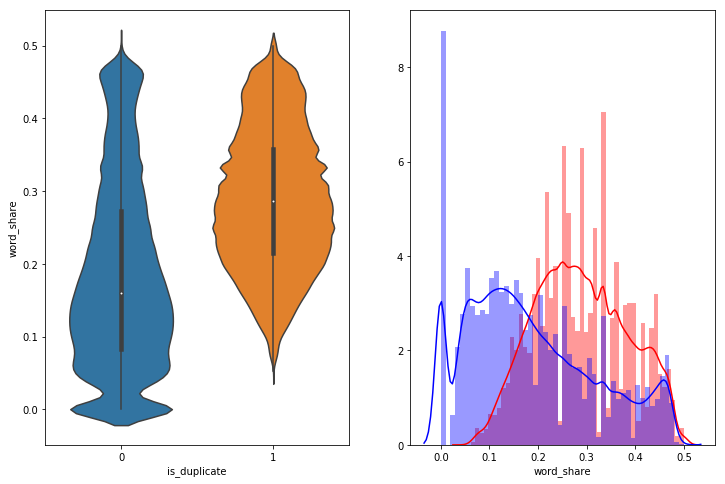

In [18]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_share', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_share'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_share'][0:] , label = "0" , color = 'blue' )
plt.show()

- The distributions for normalized word_share have some overlap on the far right-hand side, i.e., there are quite a lot of questions with high word similarity
- The average word share and Common no. of words of qid1 and qid2 is more when they are duplicate(Similar)

<h4> 3.3.1.2 Feature: word_Common </h4>

/Users/rohitbohra/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning:

Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.



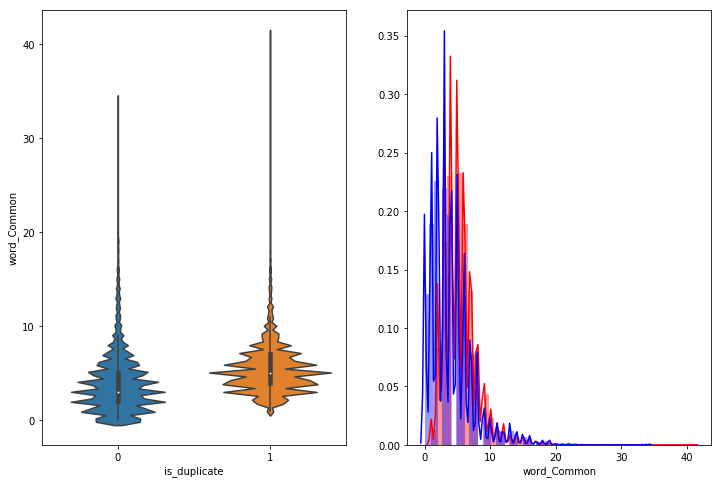

In [19]:
plt.figure(figsize=(12, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'word_Common', data = df[0:])

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['word_Common'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['word_Common'][0:] , label = "0" , color = 'blue' )
plt.show()

<p> The distributions of the word_Common feature in similar and non-similar questions are highly overlapping </p>

### 1.2.1 : EDA: Advanced Feature Extraction.



In [20]:
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
import distance
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image

In [21]:
#https://stackoverflow.com/questions/12468179/unicodedecodeerror-utf8-codec-cant-decode-byte-0x9c
if os.path.isfile('df_fe_without_preprocessing_train.csv'):
    df = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')
    df = df.fillna('')
    df.head()
else:
    print("get df_fe_without_preprocessing_train.csv from drive or run the previous notebook")

In [22]:
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words  word_Common  word_Total  \
0          1     66     57          14          12         10.0        23.0   
1          1     51     88           8          13          4.0        20.0   

   word_share  freq_q1+q2  freq_q1-q2  
0    0.434783           2           0  
1    0.200000           5           3

## 3.4 Preprocessing of Text

- Preprocessing:
    - Removing html tags 
    - Removing Punctuations
    - Performing stemming
    - Removing Stopwords
    - Expanding contractions etc.

In [23]:
# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

- Function to Compute and get the features : With 2 parameters of Question 1 and Question 2

## 3.5 Advanced Feature Extraction (NLP and Fuzzy Features) 

Definition:
- __Token__: You get a token by splitting sentence a space
- __Stop_Word__ : stop words as per NLTK.
- __Word__ : A token that is not a stop_word


Features:
- __cwc_min__ :  Ratio of common_word_count to min lenghth of word count of Q1 and Q2 <br>cwc_min = common_word_count / (min(len(q1_words), len(q2_words))
<br>
<br>
- __cwc_max__ :  Ratio of common_word_count to max lenghth of word count of Q1 and Q2 <br>cwc_max = common_word_count / (max(len(q1_words), len(q2_words))
<br>
<br>
- __csc_min__ :  Ratio of common_stop_count to min lenghth of stop count of Q1 and Q2 <br> csc_min = common_stop_count / (min(len(q1_stops), len(q2_stops))
<br>
<br>
- __csc_max__ :  Ratio of common_stop_count to max lenghth of stop count of Q1 and Q2<br>csc_max = common_stop_count / (max(len(q1_stops), len(q2_stops))
<br>
<br>
- __ctc_min__ :  Ratio of common_token_count to min lenghth of token count of Q1 and Q2<br>ctc_min = common_token_count / (min(len(q1_tokens), len(q2_tokens))
<br>
<br>

- __ctc_max__ :  Ratio of common_token_count to max lenghth of token count of Q1 and Q2<br>ctc_max = common_token_count / (max(len(q1_tokens), len(q2_tokens))
<br>
<br>
        
- __last_word_eq__ :  Check if First word of both questions is equal or not<br>last_word_eq = int(q1_tokens[-1] == q2_tokens[-1])
<br>
<br>

- __first_word_eq__ :  Check if First word of both questions is equal or not<br>first_word_eq = int(q1_tokens[0] == q2_tokens[0])
<br>
<br>
        
- __abs_len_diff__ :  Abs. length difference<br>abs_len_diff = abs(len(q1_tokens) - len(q2_tokens))
<br>
<br>

- __mean_len__ :  Average Token Length of both Questions<br>mean_len = (len(q1_tokens) + len(q2_tokens))/2
<br>
<br>


- __fuzz_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>

- __fuzz_partial_ratio__ :  https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_sort_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>


- __token_set_ratio__ : https://github.com/seatgeek/fuzzywuzzy#usage
http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
<br>
<br>





- __longest_substr_ratio__ :  Ratio of length longest common substring to min lenghth of token count of Q1 and Q2<br>longest_substr_ratio = len(longest common substring) / (min(len(q1_tokens), len(q2_tokens))

 

In [24]:
def get_token_features(q1, q2):
    token_features = [0.0]*10
    
    # Converting the Sentence into Tokens: 
    q1_tokens = q1.split()
    q2_tokens = q2.split()

    if len(q1_tokens) == 0 or len(q2_tokens) == 0:
        return token_features
    # Get the non-stopwords in Questions
    q1_words = set([word for word in q1_tokens if word not in STOP_WORDS])
    q2_words = set([word for word in q2_tokens if word not in STOP_WORDS])
    
    #Get the stopwords in Questions
    q1_stops = set([word for word in q1_tokens if word in STOP_WORDS])
    q2_stops = set([word for word in q2_tokens if word in STOP_WORDS])
    
    # Get the common non-stopwords from Question pair
    common_word_count = len(q1_words.intersection(q2_words))
    
    # Get the common stopwords from Question pair
    common_stop_count = len(q1_stops.intersection(q2_stops))
    
    # Get the common Tokens from Question pair
    common_token_count = len(set(q1_tokens).intersection(set(q2_tokens)))
    
    
    token_features[0] = common_word_count / (min(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[1] = common_word_count / (max(len(q1_words), len(q2_words)) + SAFE_DIV)
    token_features[2] = common_stop_count / (min(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[3] = common_stop_count / (max(len(q1_stops), len(q2_stops)) + SAFE_DIV)
    token_features[4] = common_token_count / (min(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    token_features[5] = common_token_count / (max(len(q1_tokens), len(q2_tokens)) + SAFE_DIV)
    
    # Last word of both question is same or not
    token_features[6] = int(q1_tokens[-1] == q2_tokens[-1])
    
    # First word of both question is same or not
    token_features[7] = int(q1_tokens[0] == q2_tokens[0])
    
    token_features[8] = abs(len(q1_tokens) - len(q2_tokens))
    
    #Average Token Length of both Questions
    token_features[9] = (len(q1_tokens) + len(q2_tokens))/2
    return token_features

# get the Longest Common sub string

def get_longest_substr_ratio(a, b):
    strs = list(distance.lcsubstrings(a, b))
    if len(strs) == 0:
        return 0
    else:
        return len(strs[0]) / (min(len(a), len(b)) + 1)

def extract_features(df):
    # preprocessing each question
    df["question1"] = df["question1"].fillna("").apply(preprocess)
    df["question2"] = df["question2"].fillna("").apply(preprocess)

    print("token features...")
    
    # Merging Features with dataset
    
    token_features = df.apply(lambda x: get_token_features(x["question1"], x["question2"]), axis=1)
    
    df["cwc_min"]       = list(map(lambda x: x[0], token_features))
    df["cwc_max"]       = list(map(lambda x: x[1], token_features))
    df["csc_min"]       = list(map(lambda x: x[2], token_features))
    df["csc_max"]       = list(map(lambda x: x[3], token_features))
    df["ctc_min"]       = list(map(lambda x: x[4], token_features))
    df["ctc_max"]       = list(map(lambda x: x[5], token_features))
    df["last_word_eq"]  = list(map(lambda x: x[6], token_features))
    df["first_word_eq"] = list(map(lambda x: x[7], token_features))
    df["abs_len_diff"]  = list(map(lambda x: x[8], token_features))
    df["mean_len"]      = list(map(lambda x: x[9], token_features))
   
    #Computing Fuzzy Features and Merging with Dataset
    
    # do read this blog: http://chairnerd.seatgeek.com/fuzzywuzzy-fuzzy-string-matching-in-python/
    # https://stackoverflow.com/questions/31806695/when-to-use-which-fuzz-function-to-compare-2-strings
    # https://github.com/seatgeek/fuzzywuzzy
    print("fuzzy features..")

    df["token_set_ratio"]       = df.apply(lambda x: fuzz.token_set_ratio(x["question1"], x["question2"]), axis=1)
    # The token sort approach involves tokenizing the string in question, sorting the tokens alphabetically, and 
    # then joining them back into a string We then compare the transformed strings with a simple ratio().
    df["token_sort_ratio"]      = df.apply(lambda x: fuzz.token_sort_ratio(x["question1"], x["question2"]), axis=1)
    df["fuzz_ratio"]            = df.apply(lambda x: fuzz.QRatio(x["question1"], x["question2"]), axis=1)
    df["fuzz_partial_ratio"]    = df.apply(lambda x: fuzz.partial_ratio(x["question1"], x["question2"]), axis=1)
    df["longest_substr_ratio"]  = df.apply(lambda x: get_longest_substr_ratio(x["question1"], x["question2"]), axis=1)
    return df

In [25]:
if os.path.isfile('nlp_features_train.csv'):
    df = pd.read_csv("nlp_features_train.csv",encoding='latin-1')
    df.fillna(' ')
else:
    print("Extracting features for train:")
    df = pd.read_csv("train.csv")
    df = extract_features(df)
    df.to_csv("nlp_features_train.csv", index=False)
df.head(2)

id  qid1  qid2                                          question1  \
0   0     1     2  what is the step by step guide to invest in sh...   
1   1     3     4  what is the story of kohinoor  koh i noor  dia...   

                                           question2  is_duplicate   cwc_min  \
0  what is the step by step guide to invest in sh...             0  0.999980   
1  what would happen if the indian government sto...             0  0.799984   

    cwc_max   csc_min   csc_max          ...            ctc_max  last_word_eq  \
0  0.833319  0.999983  0.999983          ...           0.785709           0.0   
1  0.399996  0.749981  0.599988          ...           0.466664           0.0   

   first_word_eq  abs_len_diff  mean_len  token_set_ratio  token_sort_ratio  \
0            1.0           2.0      13.0              100                93   
1            1.0           5.0      12.5               86                63   

   fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
0          93                 100              0.982759  
1          66                  75              0.596154  

[2 rows x 21 columns]

### 3.5.1 Analysis of extracted features  

#### 3.5.1.1 Plotting Word clouds 

- Creating Word Cloud of Duplicates and Non-Duplicates Question pairs
- We can observe the most frequent occuring words

In [26]:
df_duplicate = df[df['is_duplicate'] == 1]
dfp_nonduplicate = df[df['is_duplicate'] == 0]

# Converting 2d array of q1 and q2 and flatten the array: like {{1,2},{3,4}} to {1,2,3,4}
p = np.dstack([df_duplicate["question1"], df_duplicate["question2"]]).flatten()
n = np.dstack([dfp_nonduplicate["question1"], dfp_nonduplicate["question2"]]).flatten()

print ("Number of data points in class 1 (duplicate pairs) :",len(p))
print ("Number of data points in class 0 (non duplicate pairs) :",len(n))

#Saving the np array into a text file
np.savetxt('train_p.txt', p, delimiter=' ', fmt='%s')
np.savetxt('train_n.txt', n, delimiter=' ', fmt='%s')

Number of data points in class 1 (duplicate pairs) : 298526
Number of data points in class 0 (non duplicate pairs) : 510054


In [27]:
# reading the text files and removing the Stop Words:
d = path.dirname('.')

textp_w = open(path.join(d, 'train_p.txt')).read()
textn_w = open(path.join(d, 'train_n.txt')).read()
stopwords = set(STOPWORDS)
stopwords.add("said")
stopwords.add("br")
stopwords.add(" ")
stopwords.remove("not")

stopwords.remove("no")
#stopwords.remove("good")
#stopwords.remove("love")
stopwords.remove("like")
#stopwords.remove("best")
#stopwords.remove("!")
print ("Total number of words in duplicate pair questions :",len(textp_w))
print ("Total number of words in non duplicate pair questions :",len(textn_w))

Total number of words in duplicate pair questions : 16109886
Total number of words in non duplicate pair questions : 33193130


 __ Word Clouds generated from  duplicate pair question's text __

Word Cloud for Duplicate Question pairs


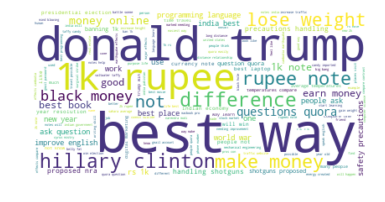

In [28]:
wc = WordCloud(background_color="white", max_words=len(textp_w), stopwords=stopwords)
wc.generate(textp_w)
print ("Word Cloud for Duplicate Question pairs")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

__ Word Clouds generated from non duplicate pair question's text __

Word Cloud for non-Duplicate Question pairs:


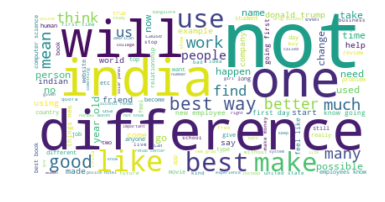

In [29]:
wc = WordCloud(background_color="white", max_words=len(textn_w),stopwords=stopwords)
# generate word cloud
wc.generate(textn_w)
print ("Word Cloud for non-Duplicate Question pairs:")
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

#### 3.5.1.2 Pair plot of features ['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'] 

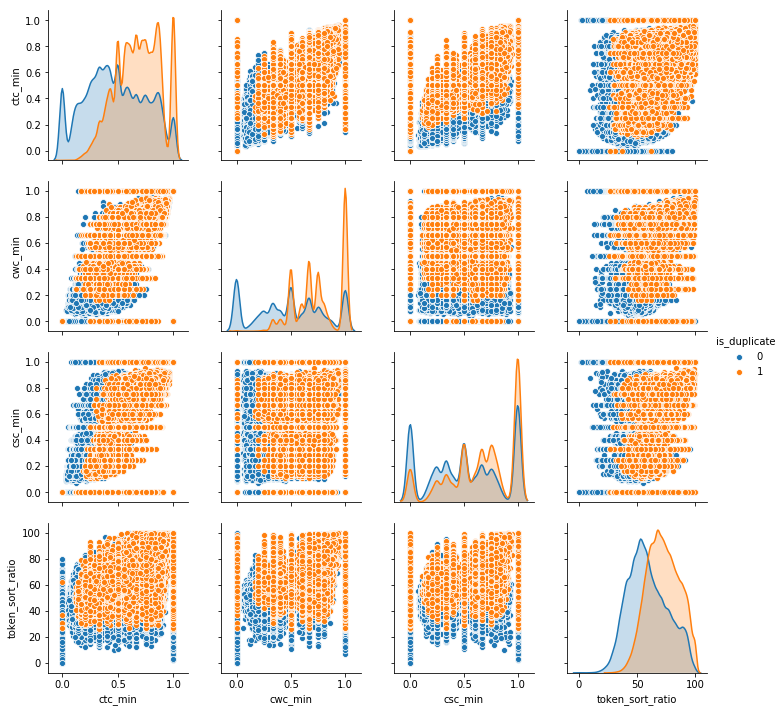

In [30]:
n = df.shape[0]
sns.pairplot(df[['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio', 'is_duplicate']][0:n], hue='is_duplicate', vars=['ctc_min', 'cwc_min', 'csc_min', 'token_sort_ratio'])
plt.show()

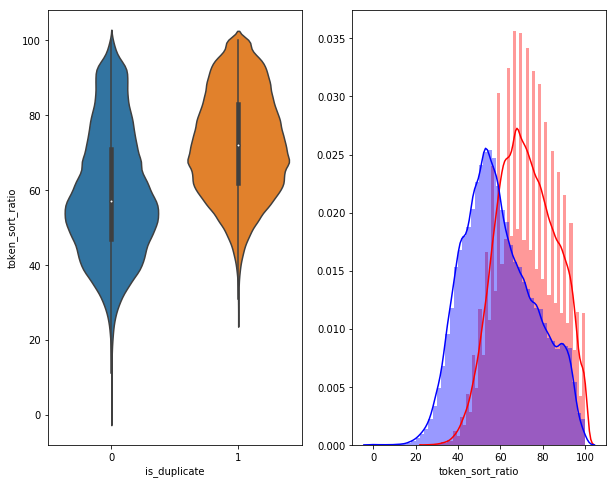

In [31]:
# Distribution of the token_sort_ratio
plt.figure(figsize=(10, 8))

plt.subplot(1,2,1)
sns.violinplot(x = 'is_duplicate', y = 'token_sort_ratio', data = df[0:] , )

plt.subplot(1,2,2)
sns.distplot(df[df['is_duplicate'] == 1.0]['token_sort_ratio'][0:] , label = "1", color = 'red')
sns.distplot(df[df['is_duplicate'] == 0.0]['token_sort_ratio'][0:] , label = "0" , color = 'blue' )
plt.show()

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/rohitbohra/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Text(0.5,0,'word match share')

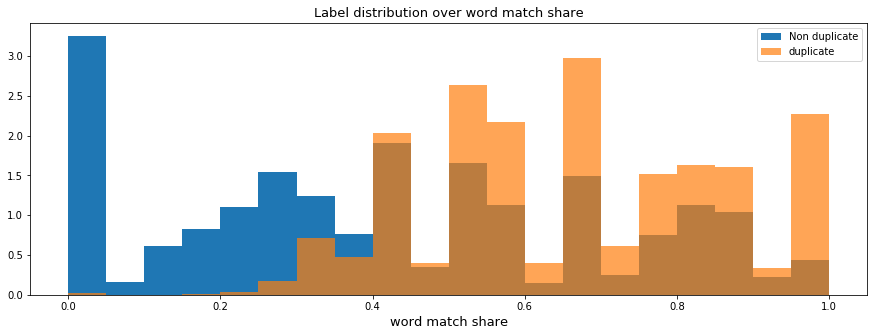

In [33]:
# To see the overlap of words in both Duplicate and non Duplicate data.

import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stops = set(stopwords.words("english"))

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        # The computer-generated chaff includes a few questions that are nothing but stopwords
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

plt.figure(figsize=(15, 5))
train_word_match = df.apply(word_match_share, axis=1, raw=True)
plt.hist(train_word_match[df['is_duplicate'] == 0], bins=20, normed=True, label='Non duplicate')
plt.hist(train_word_match[df['is_duplicate'] == 1], bins=20, normed=True, alpha=0.7, label='duplicate')
plt.legend()
plt.title('Label distribution over word match share', fontsize=13)
plt.xlabel('word match share', fontsize=13)

### 3.5.2 Visualization 

In [34]:
# Using TSNE for Dimentionality reduction for 15 Features(Generated after cleaning the data) to 3 dimention
from sklearn.preprocessing import MinMaxScaler
dfp_subsampled = df[0:5000]
X = MinMaxScaler().fit_transform(dfp_subsampled[['cwc_min', 'cwc_max', 'csc_min', 'csc_max' , 'ctc_min' , 'ctc_max' , 'last_word_eq', 'first_word_eq' , 'abs_len_diff' , 'mean_len' , 'token_set_ratio' , 'token_sort_ratio' ,  'fuzz_ratio' , 'fuzz_partial_ratio' , 'longest_substr_ratio']])
y = dfp_subsampled['is_duplicate'].values

In [35]:
tsne2d = TSNE(
    n_components=2,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.373s...
[t-SNE] Computed neighbors for 5000 samples in 0.440s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.335s
[t-SNE] Iteration 50: error = 80.9162369, gradient norm = 0.0427600 (50 iterations in 3.524s)
[t-SNE] Iteration 100: error = 70.3915100, gradient norm = 0.0108003 (50 iterations in 2.364s)
[t-SNE] Iteration 150: error = 68.6126938, gradient norm = 0.0054721 (50 iterations in 2.216s)
[t-SNE] Iteration 200: error = 67.7680206, gradient norm = 0.0042246 (50 iterations in 2.460s)
[t-SNE] Iteration 250: error = 67.2733459, gradient norm = 0.0037275

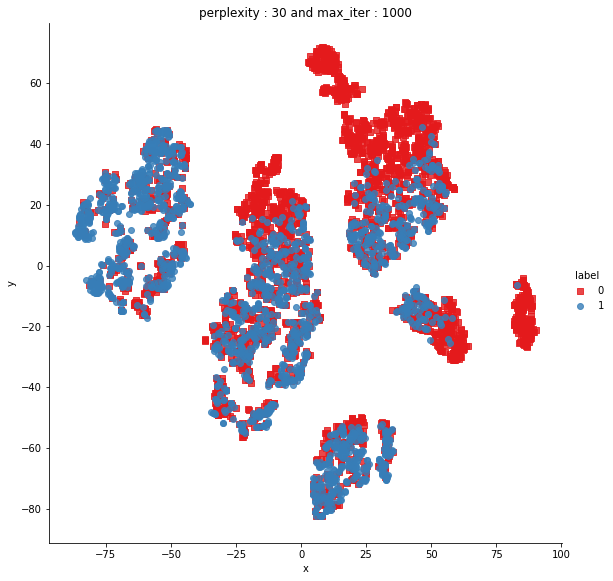

In [36]:
df = pd.DataFrame({'x':tsne2d[:,0], 'y':tsne2d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

In [37]:
from sklearn.manifold import TSNE
tsne3d = TSNE(
    n_components=3,
    init='random', # pca
    random_state=101,
    method='barnes_hut',
    n_iter=1000,
    verbose=2,
    angle=0.5
).fit_transform(X)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 5000 samples in 0.015s...
[t-SNE] Computed neighbors for 5000 samples in 0.437s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.116557
[t-SNE] Computed conditional probabilities in 0.221s
[t-SNE] Iteration 50: error = 80.3552017, gradient norm = 0.0329941 (50 iterations in 11.347s)
[t-SNE] Iteration 100: error = 69.1120148, gradient norm = 0.0033901 (50 iterations in 6.557s)
[t-SNE] Iteration 150: error = 67.6176224, gradient norm = 0.0017826 (50 iterations in 5.471s)
[t-SNE] Iteration 200: error = 67.0574570, gradient norm = 0.0014586 (50 iterations in 5.113s)
[t-SNE] Iteration 250: error = 66.7299194, gradient norm = 0.000906

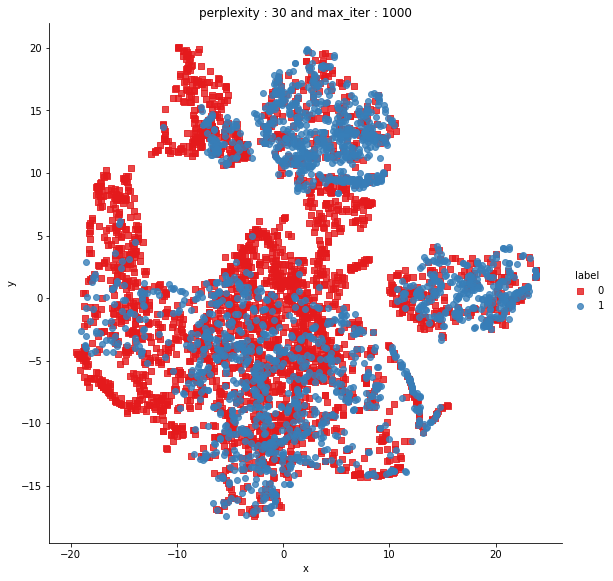

In [38]:
df = pd.DataFrame({'x':tsne3d[:,0], 'y':tsne3d[:,1] ,'label':y})

# draw the plot in appropriate place in the grid
sns.lmplot(data=df, x='x', y='y', hue='label', fit_reg=False, size=8,palette="Set1",markers=['s','o'])
plt.title("perplexity : {} and max_iter : {}".format(30, 1000))
plt.show()

# 4. Featurizing text data with tfidf weighted word-vectors

In [255]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm

# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools


In [256]:
import spacy

In [257]:
# Load Basic Features
df_basic_feature = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [258]:
# avoid decoding problems
df = pd.read_csv("train.csv")
 
# encode questions to unicode
# https://stackoverflow.com/a/6812069
# ----------------- python 2 ---------------------
# df['question1'] = df['question1'].apply(lambda x: unicode(str(x),"utf-8"))
# df['question2'] = df['question2'].apply(lambda x: unicode(str(x),"utf-8"))
# ----------------- python 3 ---------------------
df['question1'] = df['question1'].apply(lambda x: str(x))
df['question2'] = df['question2'].apply(lambda x: str(x))

In [259]:
df.head()

id  qid1  qid2                                          question1  \
0   0     1     2  What is the step by step guide to invest in sh...   
1   1     3     4  What is the story of Kohinoor (Koh-i-Noor) Dia...   
2   2     5     6  How can I increase the speed of my internet co...   
3   3     7     8  Why am I mentally very lonely? How can I solve...   
4   4     9    10  Which one dissolve in water quikly sugar, salt...   

                                           question2  is_duplicate  
0  What is the step by step guide to invest in sh...             0  
1  What would happen if the Indian government sto...             0  
2  How can Internet speed be increased by hacking...             0  
3  Find the remainder when [math]23^{24}[/math] i...             0  
4            Which fish would survive in salt water?             0

In [260]:
#Number of columns in dataframe
len(df_basic_feature.columns)

17

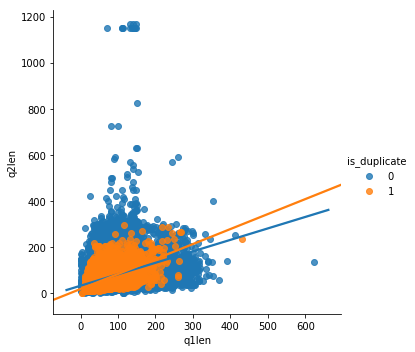

In [261]:
import seaborn as sns;
import matplotlib.pyplot as plt
ax = sns.lmplot(x="q1len", y="q2len",hue="is_duplicate", data=df_basic_feature)



In [262]:
# Loading the advanced features
df_advance_features = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [263]:
# Columns dropped from basic feature dataframe 
df_basic_feature = df_basic_feature.drop(['qid1','qid2'],axis=1)

# Columns dropped from advance feature dataframe 
df_advance_features = df_advance_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# Lets add both the truncated dataframe into one dataframe
df_basic_advance_features  = df_basic_feature.merge(df_advance_features, on='id',how='left')

In [264]:
list(df_basic_advance_features.columns.values)

['id',
 'question1',
 'question2',
 'is_duplicate',
 'freq_qid1',
 'freq_qid2',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share',
 'freq_q1+q2',
 'freq_q1-q2',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio']

In [265]:
df1 = df_basic_advance_features.dropna()
df1.isnull().any().sum()

0

In [266]:
df1['is_duplicate'].value_counts()

0    255024
1    149263
Name: is_duplicate, dtype: int64

In [267]:
dff = df1.head(100000) 

In [269]:
dff.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [270]:
dff.shape

(100000, 30)

In [271]:
dff.head(2)

id                                          question1  \
0   0  What is the step by step guide to invest in sh...   
1   1  What is the story of Kohinoor (Koh-i-Noor) Dia...   

                                           question2  is_duplicate  freq_qid1  \
0  What is the step by step guide to invest in sh...             0          1   
1  What would happen if the Indian government sto...             0          4   

   freq_qid2  q1len  q2len  q1_n_words  q2_n_words          ...           \
0          1     66     57          14          12          ...            
1          1     51     88           8          13          ...            

    ctc_max  last_word_eq  first_word_eq  abs_len_diff  mean_len  \
0  0.785709           0.0            1.0           2.0      13.0   
1  0.466664           0.0            1.0           5.0      12.5   

   token_set_ratio  token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  \
0              100                93          93                 100   
1               86                63          66                  75   

   longest_substr_ratio  
0              0.982759  
1              0.596154  

[2 rows x 30 columns]

In [272]:
from sklearn.model_selection import train_test_split
x_train,x_test, y_train, y_test = train_test_split(dff, dff['is_duplicate'], test_size=0.3)

print(x_train.shape)
print(x_test.shape)

(70000, 30)
(30000, 30)


In [298]:
y_train.value_counts()

0    43871
1    26129
Name: is_duplicate, dtype: int64

In [299]:
y_test.value_counts()

0    18875
1    11125
Name: is_duplicate, dtype: int64

In [273]:
x_train.columns

Index(['id', 'question1', 'question2', 'is_duplicate', 'freq_qid1',
       'freq_qid2', 'q1len', 'q2len', 'q1_n_words', 'q2_n_words',
       'word_Common', 'word_Total', 'word_share', 'freq_q1+q2', 'freq_q1-q2',
       'cwc_min', 'cwc_max', 'csc_min', 'csc_max', 'ctc_min', 'ctc_max',
       'last_word_eq', 'first_word_eq', 'abs_len_diff', 'mean_len',
       'token_set_ratio', 'token_sort_ratio', 'fuzz_ratio',
       'fuzz_partial_ratio', 'longest_substr_ratio'],
      dtype='object')

In [274]:
# merge texts
questions_train = list(x_train['question1']) + list(x_train['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions_train)

# dict key:word and value:tf-idf score
word2tfidf_train = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [275]:
# merge texts
questions_test = list(x_test['question1']) + list(x_test['question2'])

tfidf = TfidfVectorizer(lowercase=False, )
tfidf.fit_transform(questions_test)

# dict key:word and value:tf-idf score
word2tfidf_test = dict(zip(tfidf.get_feature_names(), tfidf.idf_))

In [276]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(x_train['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
x_train['q1_feats_m'] = list(vecs1)


  1%|          | 788/70000 [00:16<24:41, 46.72it/s]


  2%|▏         | 1617/70000 [00:32<25:32, 44.63it/s]


  3%|▎         | 2447/70000 [00:49<22:02, 51.09it/s]


  5%|▍         | 3325/70000 [01:05<21:19, 52.10it/s]


  6%|▌         | 4193/70000 [01:21<20:24, 53.72it/s]


  7%|▋         | 5079/70000 [01:37<19:40, 55.02it/s]


  9%|▊         | 5968/70000 [01:52<19:12, 55.56it/s]


 10%|▉         | 6850/70000 [02:08<19:31, 53.88it/s]


 11%|█         | 7716/70000 [02:24<18:56, 54.79it/s]


 12%|█▏        | 8595/70000 [02:40<19:05, 53.60it/s]


 14%|█▎        | 9479/70000 [02:56<17:59, 56.08it/s]


 15%|█▍        | 10357/70000 [03:12<18:08, 54.78it/s]


 16%|█▌        | 11223/70000 [03:27<18:04, 54.20it/s]


 17%|█▋        | 12097/70000 [03:42<17:22, 55.55it/s]


 19%|█▊        | 12958/70000 [03:58<17:27, 54.47it/s]


 20%|█▉        | 13821/70000 [04:13<17:23, 53.84it/s]


 21%|██        | 14691/70000 [04:29<16:53, 54.59it/s]


 22%|██▏       | 15562/70000 [04:44<16:33, 54.78it/s]


 23%|██▎       | 16425/70000 [04:59<15:59, 55.86it/s]


 25%|██▍       | 17294/70000 [05:15<15:49, 55.51it/s]


 26%|██▌       | 18161/70000 [05:30<16:10, 53.42it/s]


 27%|██▋       | 19033/70000 [05:45<15:22, 55.26it/s]


 28%|██▊       | 19900/70000 [06:01<15:09, 55.11it/s]


 30%|██▉       | 20761/70000 [06:16<15:16, 53.70it/s]


 31%|███       | 21639/70000 [06:32<14:33, 55.38it/s]


 32%|███▏      | 22513/70000 [06:47<14:19, 55.26it/s]


 33%|███▎      | 23394/70000 [07:03<14:05, 55.14it/s]


 35%|███▍      | 24254/70000 [07:18<15:27, 49.30it/s]


 36%|███▌      | 25008/70000 [07:34<16:39, 45.01it/s]


 37%|███▋      | 25794/70000 [07:50<15:04, 48.85it/s]


 38%|███▊      | 26643/70000 [08:06<14:33, 49.63it/s]


 39%|███▉      | 27490/70000 [08:22<14:52, 47.63it/s]


 40%|████      | 28333/70000 [08:38<15:18, 45.37it/s]


 42%|████▏     | 29177/70000 [08:54<14:26, 47.11it/s]


 43%|████▎     | 30022/70000 [09:10<14:35, 45.68it/s]


 44%|████▍     | 30866/70000 [09:26<13:26, 48.52it/s]


 45%|████▌     | 31716/70000 [09:42<12:57, 49.25it/s]


 47%|████▋     | 32565/70000 [09:58<13:10, 47.38it/s]


 48%|████▊     | 33409/70000 [10:14<12:27, 48.92it/s]


 49%|████▉     | 34266/70000 [10:30<12:16, 48.50it/s]


 50%|█████     | 35110/70000 [10:46<11:55, 48.76it/s]


 51%|█████▏    | 35951/70000 [11:02<11:55, 47.59it/s]


 53%|█████▎    | 36782/70000 [11:18<11:34, 47.86it/s]


 54%|█████▍    | 37629/70000 [11:34<11:33, 46.70it/s]


 55%|█████▍    | 38473/70000 [11:50<11:28, 45.76it/s]


 56%|█████▌    | 39322/70000 [12:06<11:10, 45.74it/s]


 57%|█████▋    | 40173/70000 [12:21<10:45, 46.19it/s]


 59%|█████▊    | 41021/70000 [12:37<10:13, 47.21it/s]


 60%|█████▉    | 41860/70000 [12:53<09:40, 48.46it/s]


 61%|██████    | 42701/70000 [13:09<09:38, 47.19it/s]


 62%|██████▏   | 43541/70000 [13:25<09:30, 46.36it/s]


 63%|██████▎   | 44380/70000 [13:40<09:31, 44.85it/s]


 65%|██████▍   | 45217/70000 [13:56<09:01, 45.73it/s]


 66%|██████▌   | 46062/70000 [14:12<08:29, 46.96it/s]


 67%|██████▋   | 46911/70000 [14:28<08:26, 45.60it/s]


 68%|██████▊   | 47746/70000 [14:44<07:55, 46.78it/s]


 69%|██████▉   | 48589/70000 [14:59<07:47, 45.79it/s]


 71%|███████   | 49438/70000 [15:15<07:21, 46.62it/s]


 72%|███████▏  | 50279/70000 [15:31<07:05, 46.38it/s]


 73%|███████▎  | 51121/70000 [15:47<06:47, 46.28it/s]


 74%|███████▍  | 51962/70000 [16:02<06:14, 48.16it/s]


 75%|███████▌  | 52778/70000 [16:18<06:02, 47.55it/s]


 77%|███████▋  | 53603/70000 [16:34<05:28, 49.95it/s]


 78%|███████▊  | 54465/70000 [16:50<05:19, 48.58it/s]


 79%|███████▉  | 55334/70000 [17:06<04:57, 49.25it/s]


 80%|████████  | 56194/70000 [17:22<04:43, 48.66it/s]


 82%|████████▏ | 57053/70000 [17:37<04:29, 48.10it/s]


 83%|████████▎ | 57911/70000 [17:53<04:15, 47.40it/s]


 84%|████████▍ | 58775/70000 [18:09<03:45, 49.79it/s]


 85%|████████▌ | 59650/70000 [18:24<03:30, 49.14it/s]


 86%|████████▋ | 60477/70000 [18:40<03:16, 48.55it/s]


 88%|████████▊ | 61335/70000 [18:56<02:56, 49.13it/s]


 89%|████████▉ | 62193/70000 [19:12<02:44, 47.60it/s]


 90%|█████████ | 63048/70000 [19:27<02:23, 48.42it/s]


 91%|█████████▏| 63911/70000 [19:43<02:08, 47.53it/s]


 93%|█████████▎| 64766/70000 [19:59<01:55, 45.28it/s]


 94%|█████████▎| 65620/70000 [20:14<01:32, 47.43it/s]


 95%|█████████▍| 66473/70000 [20:30<01:16, 46.17it/s]


 96%|█████████▌| 67324/70000 [20:45<00:56, 46.97it/s]


 97%|█████████▋| 68167/70000 [21:01<00:39, 46.74it/s]


 99%|█████████▊| 69027/70000 [21:17<00:19, 49.24it/s]


100%|█████████▉| 69872/70000 [21:32<00:02, 47.28it/s]


100%|██████████| 70000/70000 [21:35<00:00, 55.19it/s]

In [277]:
vecs2 = []
for qu2 in tqdm(list(x_train['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_train[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
x_train['q2_feats_m'] = list(vecs2)


  1%|▏         | 888/70000 [00:16<20:38, 55.82it/s]


  3%|▎         | 1758/70000 [00:32<22:17, 51.03it/s]


  4%|▍         | 2637/70000 [00:48<21:03, 53.32it/s]


  5%|▌         | 3529/70000 [01:04<20:40, 53.60it/s]


  6%|▋         | 4411/70000 [01:20<19:52, 55.02it/s]


  8%|▊         | 5296/70000 [01:35<19:50, 54.37it/s]


  9%|▉         | 6187/70000 [01:51<19:22, 54.88it/s]


 10%|█         | 7072/70000 [02:07<19:23, 54.10it/s]


 11%|█▏        | 7968/70000 [02:23<18:52, 54.78it/s]


 13%|█▎        | 8853/70000 [02:39<20:05, 50.74it/s]


 14%|█▍        | 9736/70000 [02:54<19:00, 52.84it/s]


 15%|█▌        | 10616/70000 [03:10<18:31, 53.42it/s]


 16%|█▋        | 11480/70000 [03:25<17:46, 54.85it/s]


 18%|█▊        | 12345/70000 [03:41<18:02, 53.24it/s]


 19%|█▉        | 13215/70000 [03:56<16:54, 56.00it/s]


 20%|██        | 14091/70000 [04:12<17:15, 53.99it/s]


 21%|██▏       | 14972/70000 [04:27<17:14, 53.17it/s]


 23%|██▎       | 15832/70000 [04:43<16:33, 54.54it/s]


 24%|██▍       | 16702/70000 [04:58<16:46, 52.95it/s]


 25%|██▌       | 17578/70000 [05:14<16:07, 54.18it/s]


 26%|██▋       | 18449/70000 [05:29<16:17, 52.76it/s]


 28%|██▊       | 19318/70000 [05:45<15:35, 54.20it/s]


 29%|██▉       | 20183/70000 [06:00<14:59, 55.36it/s]


 30%|███       | 21048/70000 [06:16<16:14, 50.25it/s]


 31%|███▏      | 21915/70000 [06:31<14:39, 54.70it/s]


 33%|███▎      | 22781/70000 [06:47<14:00, 56.19it/s]


 34%|███▍      | 23646/70000 [07:02<13:58, 55.27it/s]


 35%|███▌      | 24524/70000 [07:18<14:02, 54.00it/s]


 36%|███▋      | 25408/70000 [07:33<13:56, 53.28it/s]


 38%|███▊      | 26276/70000 [07:49<12:59, 56.11it/s]


 39%|███▉      | 27142/70000 [08:04<12:35, 56.75it/s]


 40%|████      | 28014/70000 [08:20<12:48, 54.66it/s]


 41%|████▏     | 28881/70000 [08:35<12:10, 56.28it/s]


 42%|████▏     | 29744/70000 [08:50<12:24, 54.09it/s]


 44%|████▎     | 30608/70000 [09:06<11:56, 54.96it/s]


 45%|████▍     | 31485/70000 [09:21<11:39, 55.07it/s]


 46%|████▌     | 32349/70000 [09:37<11:34, 54.22it/s]


 47%|████▋     | 33214/70000 [09:52<11:32, 53.10it/s]


 49%|████▊     | 34086/70000 [10:08<10:44, 55.72it/s]


 50%|████▉     | 34955/70000 [10:23<10:40, 54.72it/s]


 51%|█████     | 35834/70000 [10:39<10:30, 54.15it/s]


 52%|█████▏    | 36707/70000 [10:54<10:38, 52.15it/s]


 54%|█████▎    | 37578/70000 [11:10<09:56, 54.36it/s]


 55%|█████▍    | 38445/70000 [11:25<09:40, 54.36it/s]


 56%|█████▌    | 39312/70000 [11:41<09:13, 55.43it/s]


 57%|█████▋    | 40185/70000 [11:56<08:59, 55.25it/s]


 59%|█████▊    | 41049/70000 [12:12<08:53, 54.25it/s]


 60%|█████▉    | 41916/70000 [12:27<08:45, 53.43it/s]


 61%|██████    | 42790/70000 [12:43<08:15, 54.89it/s]


 62%|██████▏   | 43667/70000 [12:58<08:05, 54.20it/s]


 64%|██████▎   | 44543/70000 [13:14<07:33, 56.19it/s]


 65%|██████▍   | 45407/70000 [13:29<07:40, 53.37it/s]


 66%|██████▌   | 46279/70000 [13:44<07:22, 53.67it/s]


 67%|██████▋   | 47148/70000 [14:00<07:04, 53.86it/s]


 69%|██████▊   | 48027/70000 [14:15<06:39, 54.93it/s]


 70%|██████▉   | 48895/70000 [14:31<06:35, 53.39it/s]


 71%|███████   | 49758/70000 [14:47<06:09, 54.84it/s]


 72%|███████▏  | 50625/70000 [15:02<05:47, 55.83it/s]


 74%|███████▎  | 51494/70000 [15:17<05:42, 54.10it/s]


 75%|███████▍  | 52363/70000 [15:33<05:23, 54.54it/s]


 76%|███████▌  | 53230/70000 [15:48<05:13, 53.48it/s]


 77%|███████▋  | 54097/70000 [16:04<04:52, 54.28it/s]


 79%|███████▊  | 54960/70000 [16:19<04:40, 53.53it/s]


 80%|███████▉  | 55840/70000 [16:34<04:24, 53.47it/s]


 81%|████████  | 56708/70000 [16:50<03:51, 57.33it/s]


 82%|████████▏ | 57577/70000 [17:05<03:46, 54.91it/s]


 83%|████████▎ | 58444/70000 [17:21<03:30, 55.01it/s]


 85%|████████▍ | 59310/70000 [17:36<03:24, 52.39it/s]


 86%|████████▌ | 60182/70000 [17:52<02:56, 55.49it/s]


 87%|████████▋ | 61049/70000 [18:07<02:50, 52.37it/s]


 88%|████████▊ | 61911/70000 [18:22<02:28, 54.59it/s]


 90%|████████▉ | 62781/70000 [18:38<02:10, 55.45it/s]


 91%|█████████ | 63652/70000 [18:53<01:58, 53.46it/s]


 92%|█████████▏| 64530/70000 [19:09<01:40, 54.34it/s]


 93%|█████████▎| 65407/70000 [19:24<01:22, 55.67it/s]


 95%|█████████▍| 66262/70000 [19:40<01:11, 52.05it/s]


 96%|█████████▌| 67061/70000 [19:56<01:03, 46.40it/s]


 97%|█████████▋| 67838/70000 [20:12<00:41, 52.06it/s]


 98%|█████████▊| 68674/70000 [20:27<00:24, 54.05it/s]


 99%|█████████▉| 69558/70000 [20:43<00:08, 54.65it/s]


100%|██████████| 70000/70000 [20:51<00:00, 55.93it/s]

In [278]:
# en_vectors_web_lg, which includes over 1 million unique vectors.
nlp = spacy.load('en_core_web_sm')

vecs1 = []
# https://github.com/noamraph/tqdm
# tqdm is used to print the progress bar
for qu1 in tqdm(list(x_test['question1'])):
    doc1 = nlp(qu1) 
    # 384 is the number of dimensions of vectors 
    mean_vec1 = np.zeros([len(doc1), 384])
    for word1 in doc1:
        # word2vec
        vec1 = word1.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word1)]
        except:
            idf = 0
        # compute final vec
        mean_vec1 += vec1 * idf
    mean_vec1 = mean_vec1.mean(axis=0)
    vecs1.append(mean_vec1)
x_test['q1_feats_m'] = list(vecs1)


  3%|▎         | 834/30000 [00:16<08:57, 54.24it/s]


  6%|▌         | 1712/30000 [00:32<08:34, 55.03it/s]


  8%|▊         | 2543/30000 [00:48<09:05, 50.34it/s]


 11%|█▏        | 3386/30000 [01:05<08:22, 53.01it/s]


 14%|█▍        | 4261/30000 [01:21<08:34, 49.98it/s]


 17%|█▋        | 5118/30000 [01:37<08:02, 51.62it/s]


 20%|█▉        | 5923/30000 [01:54<07:28, 53.64it/s]


 23%|██▎       | 6764/30000 [02:10<07:38, 50.68it/s]


 25%|██▌       | 7648/30000 [02:26<06:38, 56.16it/s]


 28%|██▊       | 8528/30000 [02:42<06:36, 54.11it/s]


 31%|███▏      | 9411/30000 [02:57<06:16, 54.62it/s]


 34%|███▍      | 10266/30000 [03:13<06:31, 50.44it/s]


 37%|███▋      | 11124/30000 [03:29<05:58, 52.69it/s]


 40%|███▉      | 11949/30000 [03:46<05:32, 54.29it/s]


 43%|████▎     | 12812/30000 [04:01<05:21, 53.53it/s]


 46%|████▌     | 13674/30000 [04:16<04:52, 55.82it/s]


 48%|████▊     | 14536/30000 [04:32<04:42, 54.83it/s]


 51%|█████▏    | 15402/30000 [04:47<04:32, 53.57it/s]


 54%|█████▍    | 16269/30000 [05:03<04:13, 54.07it/s]


 57%|█████▋    | 17134/30000 [05:18<03:54, 54.84it/s]


 60%|██████    | 18000/30000 [05:34<03:40, 54.49it/s]


 63%|██████▎   | 18864/30000 [05:49<03:18, 55.97it/s]


 66%|██████▌   | 19728/30000 [06:05<03:08, 54.46it/s]


 69%|██████▊   | 20593/30000 [06:20<02:51, 54.86it/s]


 72%|███████▏  | 21458/30000 [06:36<02:41, 53.01it/s]


 74%|███████▍  | 22317/30000 [06:52<02:19, 55.27it/s]


 77%|███████▋  | 23135/30000 [07:08<02:20, 48.81it/s]


 80%|███████▉  | 23909/30000 [07:24<01:49, 55.52it/s]


 82%|████████▏ | 24721/30000 [07:40<01:51, 47.42it/s]


 85%|████████▌ | 25518/30000 [07:56<01:32, 48.46it/s]


 88%|████████▊ | 26359/30000 [08:12<01:08, 53.42it/s]


 91%|█████████ | 27217/30000 [08:28<00:51, 54.57it/s]


 94%|█████████▎| 28065/30000 [08:44<00:35, 54.77it/s]


 96%|█████████▋| 28924/30000 [09:00<00:20, 53.68it/s]


 99%|█████████▉| 29782/30000 [09:15<00:04, 52.97it/s]


100%|██████████| 30000/30000 [09:19<00:00, 53.59it/s]

In [279]:
vecs2 = []
for qu2 in tqdm(list(x_test['question2'])):
    doc2 = nlp(qu2) 
    mean_vec2 = np.zeros([len(doc2), 384])
    for word2 in doc2:
        # word2vec
        vec2 = word2.vector
        # fetch df score
        try:
            idf = word2tfidf_test[str(word2)]
        except:
            #print word
            idf = 0
        # compute final vec
        mean_vec2 += vec2 * idf
    mean_vec2 = mean_vec2.mean(axis=0)
    vecs2.append(mean_vec2)
x_test['q2_feats_m'] = list(vecs2)


  3%|▎         | 879/30000 [00:17<09:42, 49.96it/s]


  6%|▌         | 1761/30000 [00:33<08:52, 52.99it/s]


  9%|▉         | 2637/30000 [00:50<09:00, 50.67it/s]


 12%|█▏        | 3511/30000 [01:06<08:40, 50.90it/s]


 15%|█▍        | 4387/30000 [01:23<08:02, 53.06it/s]


 18%|█▊        | 5263/30000 [01:39<08:02, 51.28it/s]


 20%|██        | 6139/30000 [01:56<07:40, 51.85it/s]


 23%|██▎       | 7015/30000 [02:12<07:21, 52.03it/s]


 26%|██▋       | 7897/30000 [02:28<06:58, 52.76it/s]


 29%|██▉       | 8773/30000 [02:45<06:51, 51.60it/s]


 32%|███▏      | 9649/30000 [03:02<06:51, 49.45it/s]


 35%|███▌      | 10513/30000 [03:18<06:08, 52.83it/s]


 38%|███▊      | 11371/30000 [03:34<05:46, 53.83it/s]


 41%|████      | 12228/30000 [03:50<05:25, 54.60it/s]


 44%|████▎     | 13085/30000 [04:07<05:36, 50.29it/s]


 46%|████▋     | 13935/30000 [04:23<06:33, 40.86it/s]


 49%|████▉     | 14679/30000 [04:40<05:04, 50.35it/s]


 52%|█████▏    | 15465/30000 [04:56<05:24, 44.78it/s]


 54%|█████▍    | 16289/30000 [05:12<04:21, 52.41it/s]


 57%|█████▋    | 17082/30000 [05:28<04:56, 43.61it/s]


 59%|█████▉    | 17824/30000 [05:45<04:38, 43.79it/s]


 62%|██████▏   | 18548/30000 [06:01<04:29, 42.48it/s]


 65%|██████▍   | 19370/30000 [06:18<03:24, 51.93it/s]


 67%|██████▋   | 20232/30000 [06:34<03:10, 51.31it/s]


 70%|███████   | 21088/30000 [06:50<02:57, 50.29it/s]


 73%|███████▎  | 21940/30000 [07:06<02:46, 48.46it/s]


 76%|███████▌  | 22797/30000 [07:23<02:19, 51.65it/s]


 79%|███████▉  | 23651/30000 [07:39<02:00, 52.91it/s]


 82%|████████▏ | 24511/30000 [07:55<01:50, 49.81it/s]


 85%|████████▍ | 25371/30000 [08:11<01:33, 49.57it/s]


 87%|████████▋ | 26221/30000 [08:27<01:19, 47.72it/s]


 90%|█████████ | 27071/30000 [08:43<01:00, 48.13it/s]


 93%|█████████▎| 27926/30000 [08:59<00:40, 50.87it/s]


 96%|█████████▌| 28773/30000 [09:15<00:25, 47.35it/s]


 99%|█████████▊| 29621/30000 [09:32<00:08, 47.37it/s]


100%|██████████| 30000/30000 [09:39<00:00, 51.80it/s]

In [280]:
x_train.shape

(70000, 32)

In [281]:
x_test.shape

(30000, 32)

In [282]:
x_train_q1 = pd.DataFrame(x_train.q1_feats_m.values.tolist(), index= x_train.index)
x_train_q2 = pd.DataFrame(x_train.q2_feats_m.values.tolist(), index= x_train.index)

In [283]:
x_test_q1 = pd.DataFrame(x_test.q1_feats_m.values.tolist(), index= x_test.index)
x_test_q2 = pd.DataFrame(x_test.q2_feats_m.values.tolist(), index= x_test.index)

In [284]:
print(x_train_q1.shape)
print(x_train_q2.shape)
print(x_test_q1.shape)
print(x_test_q2.shape)

(70000, 384)
(70000, 384)
(30000, 384)
(30000, 384)


In [285]:
x_train = x_train.drop(['question1','question2','is_duplicate', 'q1_feats_m', 'q2_feats_m'],axis=1)

In [286]:
x_test = x_test.drop(['question1','question2','is_duplicate', 'q1_feats_m', 'q2_feats_m'],axis=1)

In [287]:
x_train.head(2)

id  freq_qid1  freq_qid2  q1len  q2len  q1_n_words  q2_n_words  \
75462  75462         15          2     31     32           6           6   
41375  41375          1          1     97    109          22          25   

       word_Common  word_Total  word_share          ...            ctc_max  \
75462          2.0        12.0    0.166667          ...           0.333328   
41375          9.0        42.0    0.214286          ...           0.384614   

       last_word_eq  first_word_eq  abs_len_diff  mean_len  token_set_ratio  \
75462           1.0            0.0           0.0       6.0               75   
41375           0.0            1.0           4.0      24.0               63   

       token_sort_ratio  fuzz_ratio  fuzz_partial_ratio  longest_substr_ratio  
75462                62          72                  71              0.281250  
41375                64          50                  49              0.091837  

[2 rows x 27 columns]

In [288]:
print(x_train.shape)
print(x_test.shape)

(70000, 27)
(30000, 27)


In [289]:
x_train_q1['id']=x_train['id']
x_train_q2['id']=x_train['id']
x_test_q1['id']=x_test['id']
x_test_q2['id']=x_test['id']

In [290]:
x_train = x_train.merge(x_train_q1, on='id',how='left')
x_train = x_train.merge(x_train_q2, on='id',how='left')

In [291]:
x_test = x_test.merge(x_test_q1, on='id',how='left')
x_test = x_test.merge(x_test_q2, on='id',how='left')

In [292]:
print(x_train.shape)
print(x_test.shape)

(70000, 795)
(30000, 795)


In [304]:
from sklearn import preprocessing

# Create the Scaler object
scaler = preprocessing.StandardScaler()
# Fit your data on the scaler object
x_train = scaler.fit_transform(x_train)


In [305]:
x_test = scaler.fit_transform(x_test)

In [307]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics.classification import accuracy_score, log_loss
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold 
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import normalized_mutual_info_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import SGDClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_recall_curve, auc, roc_curve
from mlxtend.classifier import StackingClassifier

In [317]:
from collections import Counter, defaultdict

print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.6267285714285714 Class 1:  0.3732714285714286
---------- Distribution of output variable in train data ----------
Class 0:  0.37083333333333335 Class 1:  0.37083333333333335


Log loss on Test Data using Random Model 0.885374037024287


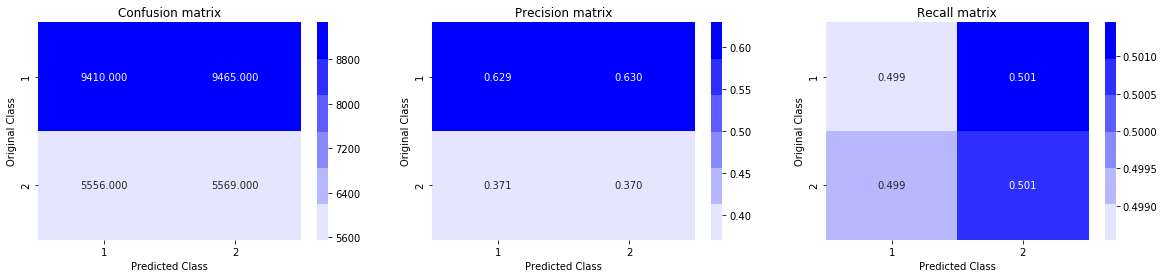

In [318]:
##  Models

# Random Model
predicted_y = np.zeros((len(y_test),2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.4661112573028649
For values of alpha =  0.0001 The log loss is: 0.4733028089896728
For values of alpha =  0.001 The log loss is: 0.44588399023613856
For values of alpha =  0.01 The log loss is: 0.41318361822661187
For values of alpha =  0.1 The log loss is: 0.4466665529061543
For values of alpha =  1 The log loss is: 0.4996575447423112
For values of alpha =  10 The log loss is: 0.5709438505035458


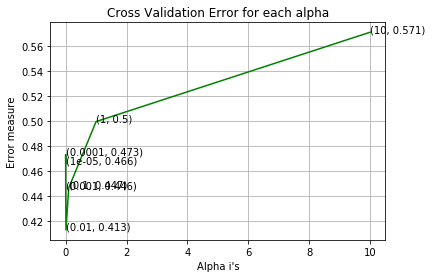

For values of best alpha =  0.01 The train log loss is: 0.40786684531981443
For values of best alpha =  0.01 The test log loss is: 0.41318361822661187
Total number of data points : 30000


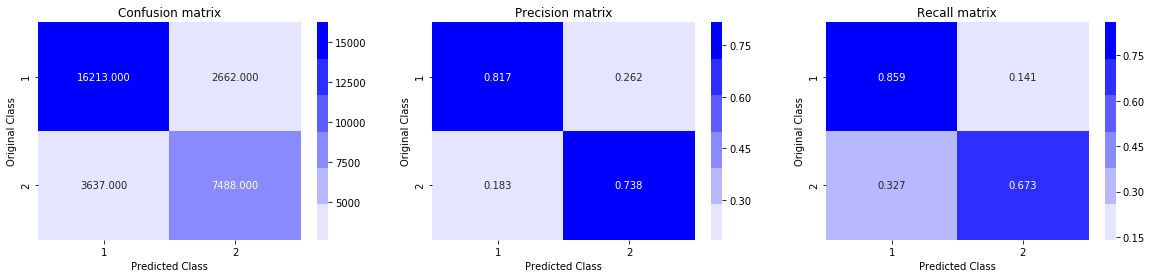

In [308]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.48017198145677364
For values of alpha =  0.0001 The log loss is: 0.48957143206751197
For values of alpha =  0.001 The log loss is: 0.45664828162701354
For values of alpha =  0.01 The log loss is: 0.4144183019700687
For values of alpha =  0.1 The log loss is: 0.43396867654766225
For values of alpha =  1 The log loss is: 0.4777497996087267
For values of alpha =  10 The log loss is: 0.5434003596204937


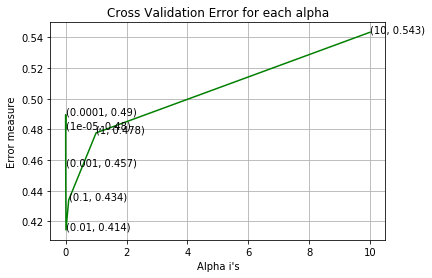

For values of best alpha =  0.01 The train log loss is: 0.4090579081312148
For values of best alpha =  0.01 The test log loss is: 0.4144183019700687
Total number of data points : 30000


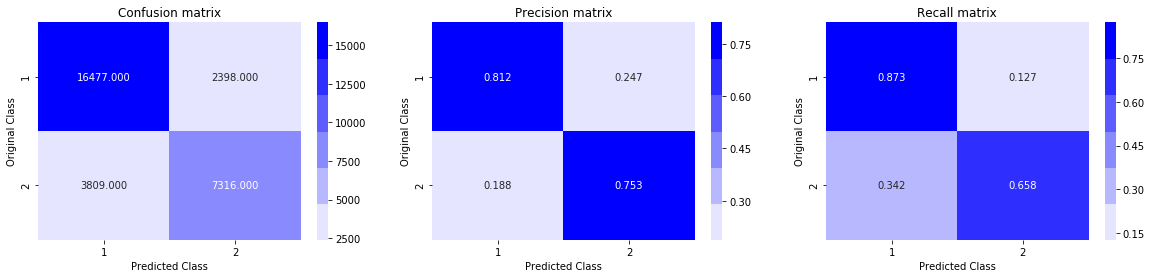

In [310]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [311]:
import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(x_train, label=y_train)
d_test = xgb.DMatrix(x_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(x_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.684939	valid-logloss:0.684966
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 20 rounds.
[10]	train-logloss:0.616287	valid-logloss:0.615908
[20]	train-logloss:0.565479	valid-logloss:0.565055
[30]	train-logloss:0.527642	valid-logloss:0.52718
[40]	train-logloss:0.498356	valid-logloss:0.49805
[50]	train-logloss:0.475679	valid-logloss:0.4754
[60]	train-logloss:0.457495	valid-logloss:0.457406
[70]	train-logloss:0.442861	valid-logloss:0.442937
[80]	train-logloss:0.430932	valid-logloss:0.431162
[90]	train-logloss:0.421187	valid-logloss:0.421589
[100]	train-logloss:0.413169	valid-logloss:0.41366
[110]	train-logloss:0.406411	valid-logloss:0.407012
[120]	train-logloss:0.400822	valid-logloss:0.401585
[130]	train-logloss:0.395954	valid-logloss:0.396923
[140]	train-logloss:0.391969	valid-logloss:0.393096
[150]	train-logloss:0.388152	valid-logloss:0.389551
[160]	train-logloss:0.385025	vali

Total number of data points : 30000


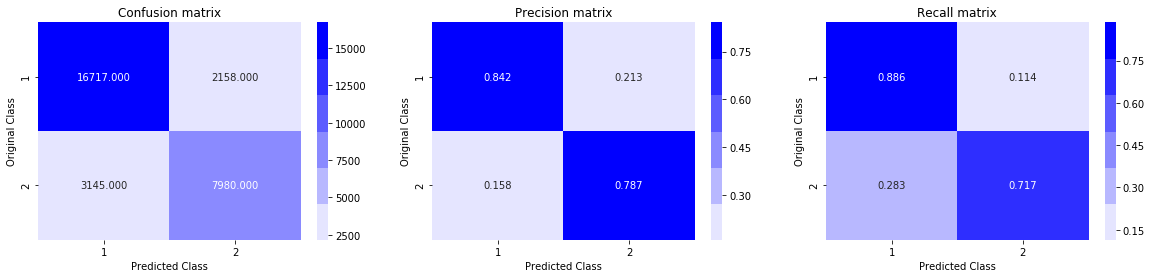

In [312]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

## USING ONLY TF-IDF Featurization instead of TF-IDF Weighted W2V technique 

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import time
import warnings
import numpy as np
from nltk.corpus import stopwords
from sklearn.preprocessing import normalize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
warnings.filterwarnings("ignore")
import sys
import os 
import pandas as pd
import numpy as np
from tqdm import tqdm
import spacy
# exctract word2vec vectors
# https://github.com/explosion/spaCy/issues/1721
# http://landinghub.visualstudio.com/visual-cpp-build-tools

In [179]:
# Load Basic Features
df_basic_feature = pd.read_csv("df_fe_without_preprocessing_train.csv",encoding='latin-1')

In [180]:
#Number of columns in dataframe
len(df_basic_feature.columns)

17

In [181]:
# list of names of columns
list(df_basic_feature.columns.values)

['id',
 'qid1',
 'qid2',
 'question1',
 'question2',
 'is_duplicate',
 'freq_qid1',
 'freq_qid2',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share',
 'freq_q1+q2',
 'freq_q1-q2']

In [182]:
# Loading the advanced features
df_advance_features = pd.read_csv("nlp_features_train.csv",encoding='latin-1')

In [183]:
#Number of columns in dataframe
len(df_advance_features.columns)

21

In [184]:
# list of names of columns
list(df_advance_features.columns.values)

['id',
 'qid1',
 'qid2',
 'question1',
 'question2',
 'is_duplicate',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio']

In [185]:
# Columns dropped from basic feature dataframe 
df_basic_feature = df_basic_feature.drop(['qid1','qid2'],axis=1)

# Columns dropped from advance feature dataframe 
df_advance_features = df_advance_features.drop(['qid1','qid2','question1','question2','is_duplicate'],axis=1)

# Lets add both the truncated dataframe into one dataframe
df_basic_advance_features  = df_basic_feature.merge(df_advance_features, on='id',how='left')

In [186]:
list(df_basic_advance_features.columns.values)

['id',
 'question1',
 'question2',
 'is_duplicate',
 'freq_qid1',
 'freq_qid2',
 'q1len',
 'q2len',
 'q1_n_words',
 'q2_n_words',
 'word_Common',
 'word_Total',
 'word_share',
 'freq_q1+q2',
 'freq_q1-q2',
 'cwc_min',
 'cwc_max',
 'csc_min',
 'csc_max',
 'ctc_min',
 'ctc_max',
 'last_word_eq',
 'first_word_eq',
 'abs_len_diff',
 'mean_len',
 'token_set_ratio',
 'token_sort_ratio',
 'fuzz_ratio',
 'fuzz_partial_ratio',
 'longest_substr_ratio']

In [187]:
y_true = df_basic_advance_features['is_duplicate']

In [188]:
df_basic_advance_features = df_basic_advance_features.drop(['id'],axis=1)
df_basic_advance_features = df_basic_advance_features.drop(['is_duplicate'],axis=1)

In [189]:
null_columns=df_basic_advance_features.columns[df_basic_advance_features.isnull().any()]
df_basic_advance_features[null_columns].isnull().sum()

question1    1
question2    2
dtype: int64

In [190]:
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup


# To get the results in 4 decemal points
SAFE_DIV = 0.0001 

STOP_WORDS = stopwords.words("english")


def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [255]:
# preprocessing each question
df_basic_advance_features['question1'] = df_basic_advance_features['question1'].apply(preprocess)
df_basic_advance_features['question2'] = df_basic_advance_features['question2'].apply(preprocess)

In [256]:
df_basic_advance_features['question1'] = df_basic_advance_features['question1'].apply(lambda x: str(x))
df_basic_advance_features['question2'] = df_basic_advance_features['question2'].apply(lambda x: str(x))

In [198]:
df_basic_advance_features["question1"] = df_basic_advance_features["question1"].fillna(" ").apply(preprocess)
df_basic_advance_features["question2"] = df_basic_advance_features["question2"].fillna(" ").apply(preprocess)

In [257]:
df_basic_advance_features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 404290 entries, 0 to 404289
Data columns (total 28 columns):
question1               404290 non-null object
question2               404290 non-null object
freq_qid1               404290 non-null int64
freq_qid2               404290 non-null int64
q1len                   404290 non-null int64
q2len                   404290 non-null int64
q1_n_words              404290 non-null int64
q2_n_words              404290 non-null int64
word_Common             404290 non-null float64
word_Total              404290 non-null float64
word_share              404290 non-null float64
freq_q1+q2              404290 non-null int64
freq_q1-q2              404290 non-null int64
cwc_min                 404290 non-null float64
cwc_max                 404290 non-null float64
csc_min                 404290 non-null float64
csc_max                 404290 non-null float64
ctc_min                 404290 non-null float64
ctc_max                 404290 non-null flo

In [271]:
x_train,x_test, y_train, y_test = train_test_split(df_basic_advance_features, y_true, stratify=y_true, test_size=0.3)

In [272]:
print("The shape of train data is ",x_train.shape)
print("The shape of Y train data is ",y_train.shape)
print("The shape of test data is ",x_test.shape)
print("The shape of Y test data is ",y_test.shape)

The shape of train data is  (283003, 28)
The shape of Y train data is  (283003,)
The shape of test data is  (121287, 28)
The shape of Y test data is  (121287,)


In [273]:
tfidf = TfidfVectorizer()

train_X = x_train['question1'] + x_train['question2']
question1_question2_train = tfidf.fit_transform(train_X)

test_X = x_test['question1'] + x_test['question2']
question1_question2_test = tfidf.transform(test_X)


print("The shape of test data is ",question1_question2_train.shape)
print("The shape of Y test data is ",question1_question2_test.shape)

The shape of test data is  (283003, 74077)
The shape of Y test data is  (121287, 74077)


In [278]:
x_train = x_train.drop(['question1'],axis=1)

In [279]:
x_test=x_test.drop(['question2'],axis=1)

In [281]:
x_train = x_train.drop(['question2'],axis=1)
x_test=x_test.drop(['question1'],axis=1)

In [282]:
x_train = hstack((x_train, question1_question2_train),dtype='float64').tocsr()
x_test = hstack((x_test, question1_question2_test),dtype='float64').tocsr()


In [228]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question1_train = TfidfVectorizer(ngram_range = (1,2), min_df=3)

question1_train = tfidfVectorizer_question1_train.fit_transform(x_train['question1'].values.astype('U'))

In [229]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question2_train = TfidfVectorizer(ngram_range = (1,2), min_df=3)

question2_train = tfidfVectorizer_question2_train.fit_transform(x_train['question2'].values.astype('U'))

In [230]:
# Instanciate Tfidf Vectorizer 
tfidfVectorizer_question1_test = TfidfVectorizer(ngram_range = (1,2), min_df=3)

question1_test = tfidfVectorizer_question1_test.fit_transform(x_test['question1'].values.astype('U'))

tfidfVectorizer_question2_test = TfidfVectorizer(ngram_range = (1,2), min_df=3)

question2_test = tfidfVectorizer_question2_test.fit_transform(x_test['question2'].values.astype('U'))

In [231]:
question1_question2_train = hstack((question1_train,question2_train))
question1_question2_test = hstack((question1_test,question2_test))

In [232]:
type(question1_question2_train)


scipy.sparse.coo.coo_matrix

In [233]:
# Drop unnecessary question1 and question2 columns
x_train.drop(['question1','question2'], axis=1, inplace=True)

In [234]:
# Drop unnecessary question1 and question2 columns
x_test.drop(['question1','question2'], axis=1, inplace=True)

In [235]:
# Combine all basic, advance and tfidf features
x_train = hstack((X_train, question1_question2_train),format="csr",dtype='float64')

In [236]:
# Combine all basic, advance and tfidf features
x_test = hstack((X_test, question1_question2_test),format="csr",dtype='float64')

In [283]:
x_train.shape

(283003, 74103)

In [284]:
x_test.shape

(121287, 74103)

In [285]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)   
    A =(((C.T)/(C.sum(axis=1))).T)
    B =(C/C.sum(axis=0))
 
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Log loss on Test Data using Random Model 0.6978384229962716


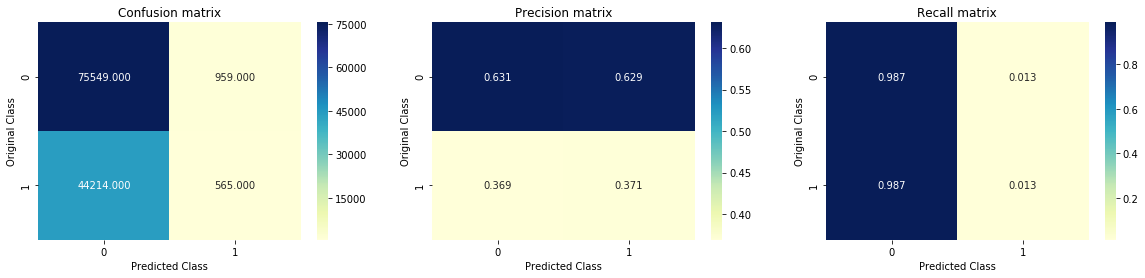

In [286]:
##  Models

# Random Model
predicted_y = np.zeros((len(y_test),2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)


For values of alpha =  1e-05 The log loss is: 0.45222282457073765
For values of alpha =  0.0001 The log loss is: 0.4438136398168544
For values of alpha =  0.001 The log loss is: 0.44421058215133563
For values of alpha =  0.01 The log loss is: 0.44406531462283577
For values of alpha =  0.1 The log loss is: 0.45716077943043243
For values of alpha =  1 The log loss is: 0.4917796143696626
For values of alpha =  10 The log loss is: 0.5452455477724563


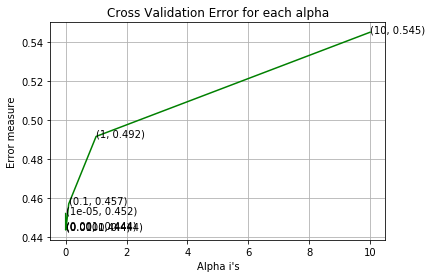

For values of best alpha =  0.0001 The train log loss is: 0.4461478534986376
For values of best alpha =  0.0001 The test log loss is: 0.4438136398168544
Total number of data points : 121287


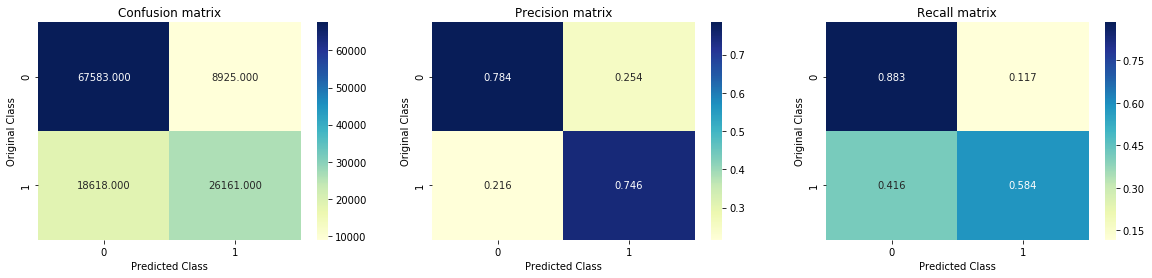

In [287]:
# logistic regression

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.
log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(x_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

For values of alpha =  1e-05 The log loss is: 0.4443182937236933
For values of alpha =  0.0001 The log loss is: 0.4446676661749702
For values of alpha =  0.001 The log loss is: 0.44695080803075365
For values of alpha =  0.01 The log loss is: 0.4449931122995938
For values of alpha =  0.1 The log loss is: 0.45382778060219536
For values of alpha =  1 The log loss is: 0.48516772493285976
For values of alpha =  10 The log loss is: 0.5444155987261744


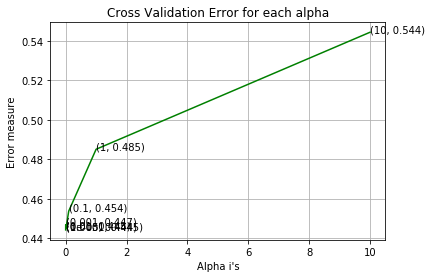

For values of best alpha =  1e-05 The train log loss is: 0.4466625001999097
For values of best alpha =  1e-05 The test log loss is: 0.4443182937236933
Total number of data points : 121287


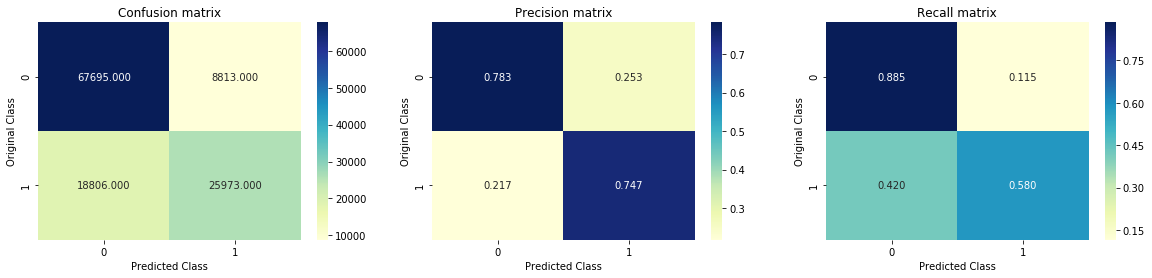

In [290]:
#SVM

alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='hinge', random_state=42)
    clf.fit(train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    sig_clf.fit(x_train, y_train)
    predict_y = sig_clf.predict_proba(x_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='hinge', random_state=42)
clf.fit(x_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
sig_clf.fit(x_train, y_train)

predict_y = sig_clf.predict_proba(x_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(x_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [293]:
from xgboost import XGBClassifier
import scipy.stats as sc
from sklearn.model_selection import RandomizedSearchCV,StratifiedKFold

In [295]:
# Hyperparameters
learning_rate = sc.uniform(0.01,0.1)
base_learners = sc.randint(10,200)
depth = sc.randint(5,10)
min_child_weight = sc.randint(5,10)

params = {'learning_rate': learning_rate, 'n_estimators':base_learners, 'max_depth':depth, 'min_child_weight':min_child_weight}

xgb_classifier = xgb.XGBClassifier(objective='binary:logistic')
gsv = RandomizedSearchCV(xgb_classifier, params, cv=3, scoring="neg_log_loss", verbose=1, random_state=0, n_jobs=-1)
gsv.fit(x_train,y_train)

print("Best Hyperparameter: ", gsv.best_params_)
print("Best neg_log_loss: %.2f%%",(gsv.best_score_*100))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  30 out of  30 | elapsed: 71.1min finished


Best Hyperparameter:  {'learning_rate': 0.0364555612104627, 'max_depth': 8, 'min_child_weight': 7, 'n_estimators': 193}
Best neg_log_loss: %.2f%% -33.000159827153645


The train log loss is: 0.31688220098944414
The test log loss is: 0.32862519851050037
Total number of data points : 121287


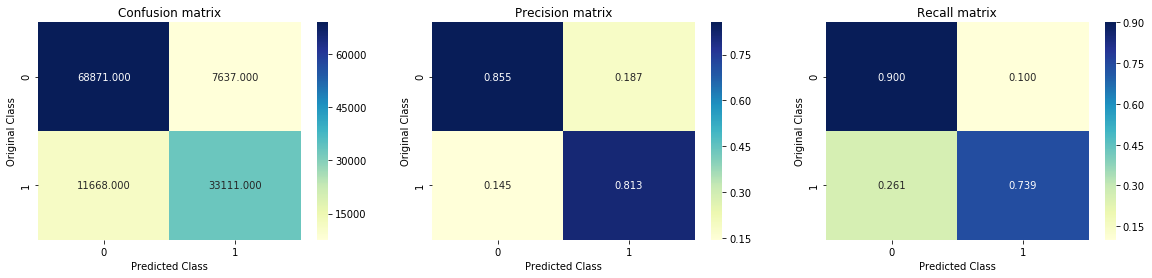

In [296]:
predict_y = gsv.predict_proba(x_train)
print("The train log loss is:",log_loss(y_train, predict_y, eps=1e-15))
predict_y = gsv.predict_proba(x_test)
print("The test log loss is:",log_loss(y_test, predict_y, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [319]:
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Model Name', 'Tokenizer', 'Test Log Loss']
x.add_row(["Random model","TFIDF Weighted W2V","0.88537"])
x.add_row(["Logistic Regression","TFIDF Weighted W2V","0.41318"])
x.add_row(["Linear SVM","TFIDF Weighted W2V","0.414418"])
x.add_row(["XG BOOST","TFIDF Weighted W2V","0.35584"])
x.add_row(["Random model","TFIDF","0.69783"])
x.add_row(["Logistic Regression","TFIDF","0.44381"])
x.add_row(["Linear SVM","TFIDF","0.444318"])
x.add_row(["XG BOOST","TFIDF","0.32862"])

print(x)

+---------------------+--------------------+---------------+
|      Model Name     |     Tokenizer      | Test Log Loss |
+---------------------+--------------------+---------------+
|     Random model    | TFIDF Weighted W2V |    0.88537    |
| Logistic Regression | TFIDF Weighted W2V |    0.41318    |
|      Linear SVM     | TFIDF Weighted W2V |    0.414418   |
|       XG BOOST      | TFIDF Weighted W2V |    0.35584    |
|     Random model    |       TFIDF        |    0.69783    |
| Logistic Regression |       TFIDF        |    0.44381    |
|      Linear SVM     |       TFIDF        |    0.444318   |
|       XG BOOST      |       TFIDF        |    0.32862    |
+---------------------+--------------------+---------------+


# Steps followed

#### 1) FOR TF-IDF Weighted W2V Featurization
 
 
       a) We build a random model, which gives a bench mark that the other models should perform better than the                           random model. The test log loss is 0.88537
 
       b) Model 1 is built using Logistic Regression algorithm and we got a Log loss of 0.41318.
 
       c) Model 2 is built using Linear Regression algorithm and we got a Log loss of 0.414418.
 
       d) Model 3 is built using XG BOOST algorithm and we got a Log loss of 0.35584.
       
       
#### 2) For TF-IDF Featurization

        a) We build a random model, which gives a bench mark that the other models should perform better than the                           random model. The test log loss is 0.69783
 
       b) Model 1 is built using Logistic Regression algorithm and we got a Log loss of 0.44381.
 
       c) Model 2 is built using Linear Regression algorithm and we got a Log loss of 0.444381.
 
       d) Model 3 is built using XG BOOST algorithm and we got a Log loss of 0.32862.
       
       

# Conclusion

1) The model was featurized using TFIDF Weighted W2V featurization and TFIDF featurization.

2) In TFIDF Weighted W2V featurization, XG BOOST algorithm performed the best with a log loss of 0.35584.

3) In TFIDF featurization, XG BOOST algorithm performed the best with a log loss of 0.32862. 